# Exploratory Data Analysis Notebook

In [180]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from data import get_raw_data, clean_data
from ts_analysis import create_multi_time_series, plot_trend, decompose_timeseries, perform_adf, fit_arima, auto_fit_arima, analyze_residuals, \
    plot_forecast_with_confidence_intervals

# setup autoreload#
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Data Preprocessing

In [55]:
raw = get_raw_data()
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17388 entries, 0 to 17387
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Data as of                                17388 non-null  object 
 1   Start Date                                17388 non-null  object 
 2   End Date                                  17388 non-null  object 
 3   Group                                     17388 non-null  object 
 4   Year                                      17334 non-null  object 
 5   Month                                     3186 non-null   float64
 6   MMWR Week                                 13878 non-null  float64
 7   Week Ending Date                          13878 non-null  object 
 8   State                                     17388 non-null  object 
 9   COVID-19 Deaths                           14128 non-null  float64
 10  Total Deaths                      

In [56]:
columns_rename_map  = {
    'COVID-19 Deaths': 'COVID-19',
    'Total Deaths': 'Total',
    'Pneumonia Deaths': 'Pneumonia',
    'Pneumonia and COVID-19 Deaths': 'Pneumonia & COVID-19',
    'Influenza Deaths': 'Influenza',
    'Pneumonia, Influenza, or COVID-19 Deaths': 'Undiagnosed'
}

raw.rename(columns=columns_rename_map, inplace=True)
raw.head()

,Data as of,Start Date,End Date,Group,Year,Month,MMWR Week,Week Ending Date,State,COVID-19,Total,Percent of Expected Deaths,Pneumonia,Pneumonia & COVID-19,Influenza,Undiagnosed,Footnote
0,12/05/2024,12/29/2019,01/04/2020,By Week,2019/2020,NaN,1.0,01/04/2020,United States,0.0,60170.0,98.0,4111.0,0.0,434.0,4545.0,NaN
1,12/05/2024,01/05/2020,01/11/2020,By Week,2020,NaN,2.0,01/11/2020,United States,1.0,60734.0,97.0,4153.0,1.0,475.0,4628.0,NaN
2,12/05/2024,01/12/2020,01/18/2020,By Week,2020,NaN,3.0,01/18/2020,United States,2.0,59362.0,98.0,4066.0,2.0,468.0,4534.0,NaN
3,12/05/2024,01/19/2020,01/25/2020,By Week,2020,NaN,4.0,01/25/2020,United States,3.0,59162.0,99.0,3915.0,0.0,500.0,4418.0,NaN
4,12/05/2024,01/26/2020,02/01/2020,By Week,2020,NaN,5.0,02/01/2020,United States,0.0,58834.0,99.0,3818.0,0.0,481.0,4299.0,NaN


In [64]:
# Columns to drop if they contain any NaN values
filter_cols = ['Start Date', 'End Date', 'MMWR Week', 'State']
# Columns to fill with 0 if they contain NaN values
data_cols = ['COVID-19', 'Total', 'Pneumonia', 'Pneumonia & COVID-19', 'Influenza', 'Undiagnosed']

clean = clean_data(df=raw, cols_drop_nan=filter_cols, cols_fill_nan=data_cols)

[INFO] Dropped 3510 rows due to NaN in ['Start Date', 'End Date', 'MMWR Week', 'State']
[INFO] Filled 3103 NaN values in column 'COVID-19'
[INFO] Filled 1 NaN values in column 'Total'
[INFO] Filled 1181 NaN values in column 'Pneumonia'
[INFO] Filled 5240 NaN values in column 'Pneumonia & COVID-19'
[INFO] Filled 5446 NaN values in column 'Influenza'
[INFO] Filled 747 NaN values in column 'Undiagnosed'


In [65]:
print(clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13878 entries, 0 to 13877
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Data as of                  13878 non-null  object        
 1   Start Date                  13878 non-null  object        
 2   End Date                    13878 non-null  datetime64[ns]
 3   Group                       13878 non-null  object        
 4   Year                        13878 non-null  int32         
 5   Month                       13878 non-null  int32         
 6   MMWR Week                   13878 non-null  float64       
 7   Week Ending Date            13878 non-null  object        
 8   State                       13878 non-null  object        
 9   COVID-19                    13878 non-null  float64       
 10  Total                       13878 non-null  float64       
 11  Percent of Expected Deaths  13878 non-null  float64       


In [66]:
display(clean[data_cols].describe())

,COVID-19,Total,Pneumonia,Pneumonia & COVID-19,Influenza,Undiagnosed
count,13878.000000,13878.00000,13878.000000,13878.000000,13878.00000,13878.000000
mean,176.494091,2317.17834,201.812725,87.099366,4.95410,295.476726
std,1017.563054,8386.16248,845.744892,527.500936,34.87645,1331.689367
min,0.000000,14.00000,0.000000,0.000000,0.00000,0.000000
25%,12.000000,359.00000,25.000000,0.000000,0.00000,34.000000
50%,28.000000,918.00000,62.000000,13.000000,0.00000,82.000000
75%,82.000000,1516.00000,118.000000,35.000000,0.00000,168.750000
max,26028.000000,87415.00000,16923.000000,13560.000000,1053.00000,29426.000000


### 2. Basic Data Visualization

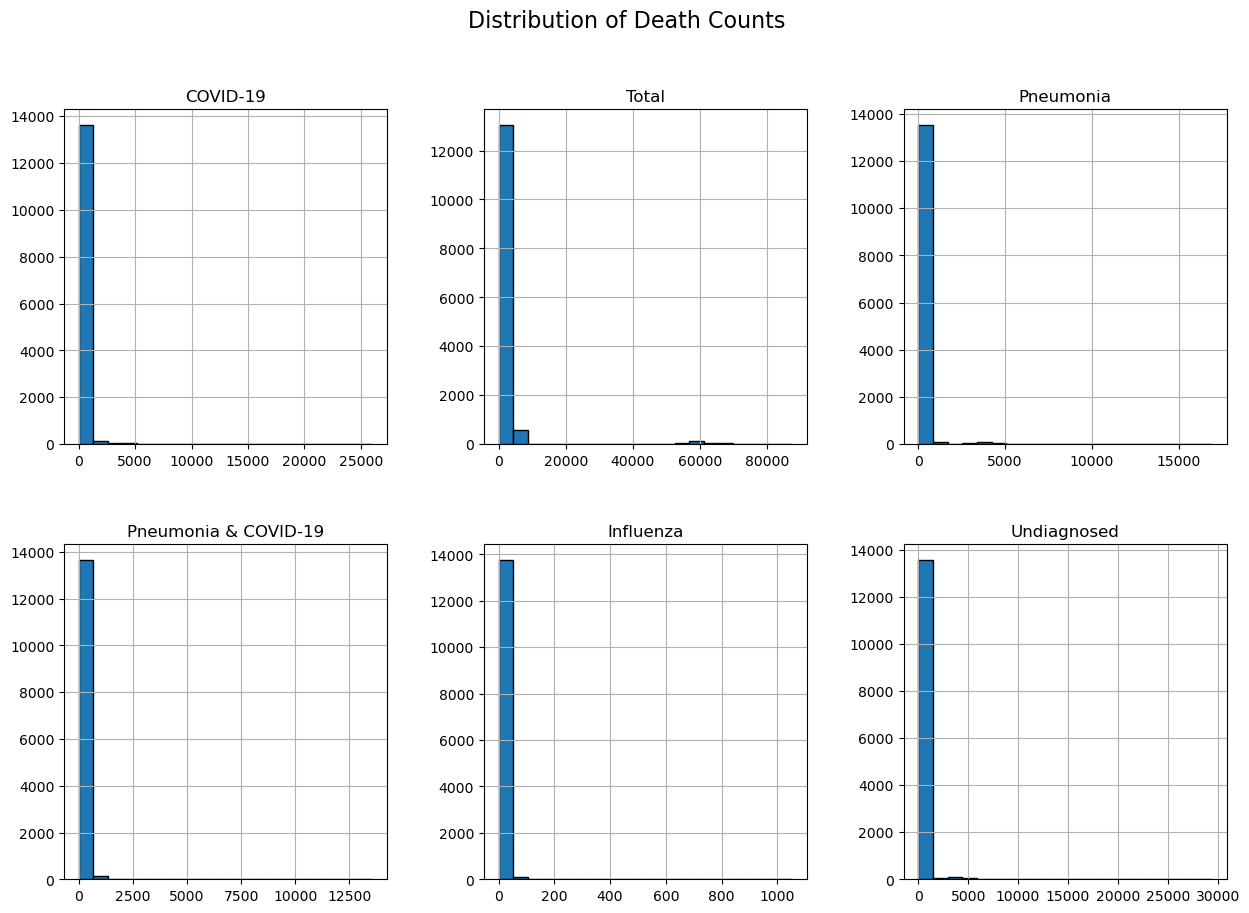

In [77]:
clean[data_cols].hist(bins=20, figsize=(15, 10), layout=(2, 3), edgecolor='black')
plt.suptitle("Distribution of Death Counts", fontsize=16)
plt.show()

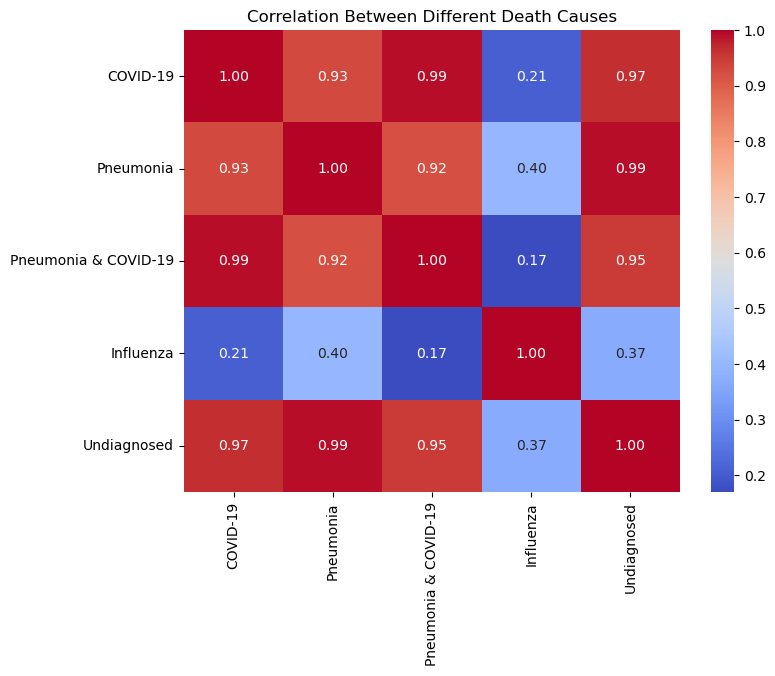

In [71]:
causes = ['COVID-19', 'Pneumonia', 'Pneumonia & COVID-19', 'Influenza', 'Undiagnosed']
# Correlation matrix
correlation_matrix = clean[causes].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Different Death Causes")
plt.show()

### 3. Time Series Analysis
Assume overall 'United States' time series as a proxy for all states.

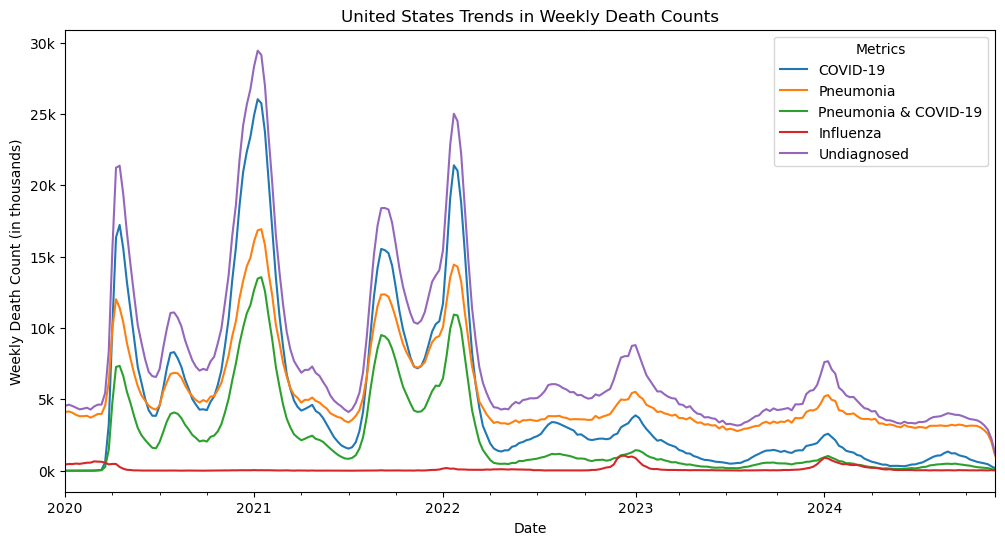

In [132]:
ts_state = 'United States'
multi_timeseries = create_multi_time_series(df=clean, metrics=causes, state=ts_state)
plot_trend(multi_timeseries)

Decomposing a time series into its components (trend, seasonality, residuals) helps understand its structure. For this we will use 'COVID-19' as a 
proxy.

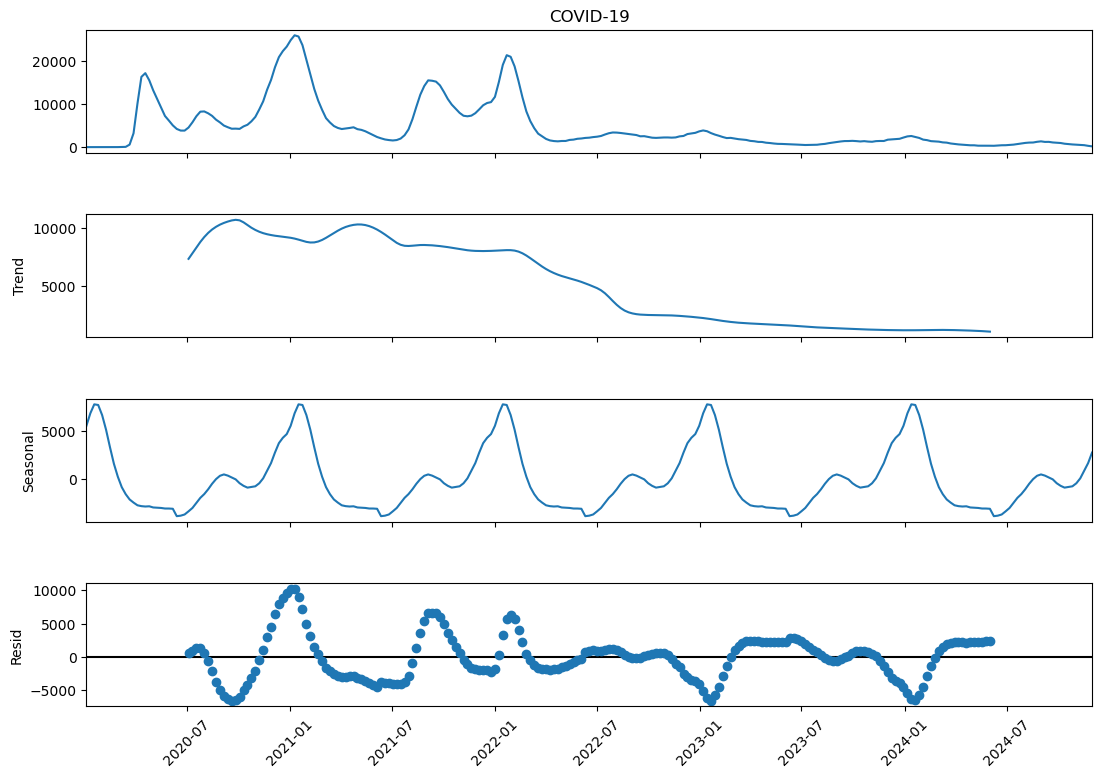

In [133]:
ts_metric = 'COVID-19'

# Infer frequency from the time series index
freq = pd.infer_freq(multi_timeseries.index)

# Set the frequency explicitly and extract specific time series 
timeseries = multi_timeseries.asfreq(freq)[ts_metric].dropna()
ts_decomposition = decompose_timeseries(timeseries)

Most time series models require the data to be stationary (constant mean and variance over time). We use the Augmented Dickey-Fuller (ADF) Test to check stationarity
.

In [134]:
perform_adf(timeseries)

ADF Statistic: -2.2028017354349743
p-value: 0.20523016049934634
The time series for is not stationary.


To make a non-stationary time series stationary, we can try to apply transformations like differencing or log transformation. We will do this until
 the time series becomes stationary (p < 0.05).

In [138]:
diff_multi_timeseries = multi_timeseries.diff()
diff_timeseries = diff_multi_timeseries.asfreq(freq)[ts_metric].dropna()

perform_adf(diff_timeseries)

ADF Statistic: -5.945332641401717
p-value: 2.21113493015698e-07
The time series for is stationary.


Differencing the timeseries once is enough to make it stationary.

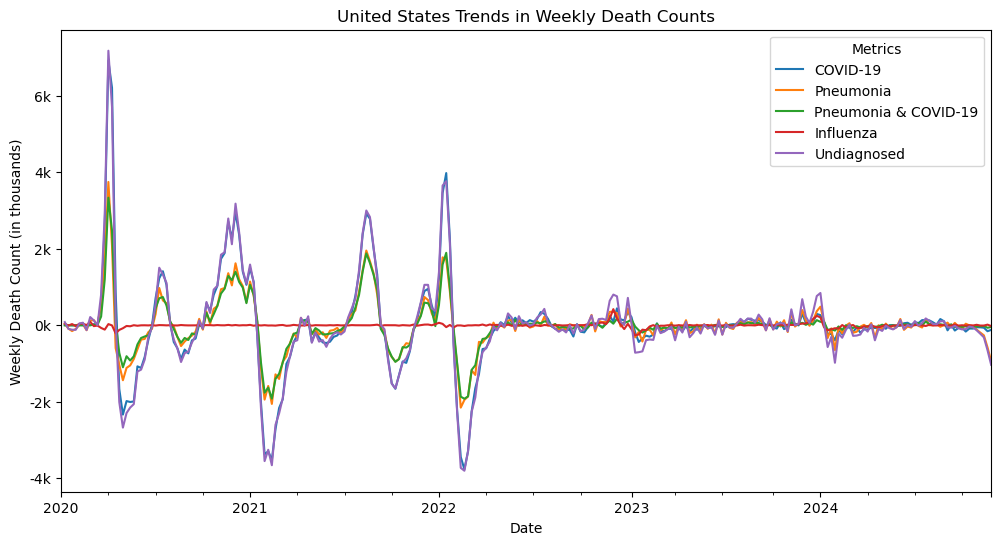

In [140]:
plot_trend(diff_multi_timeseries, ts_state)

The differenced time series reflects the local rate of change.

### 4. Time Series Modelling
We will fit an ARIMA (AutoRegressive Integrated Moving Average) model to the data, as it is well-suited for time series analysis and forecasting. ARIMA is a powerful statistical model that captures three key components of a time series: autoregression (AR), which models dependencies on past values; integration (I), which accounts for trends by differencing the data to make it stationary; and moving average (MA), which models the error term as a function of past forecast errors. By fitting an ARIMA model, we aim to understand the underlying patterns in the time series, such as trends and autocorrelations, and make accurate predictions for future values while addressing the challenges of non-stationarity often present in real-world datasets.

To fit the ARIMA model, we need to choose its parameters (\(p\), \(d\), \(q\)):

- **\(p\)**: The number of autoregressive terms, determined using the Partial Autocorrelation Function (PACF).
- **\(d\)**: The order of differencing, found by testing for stationarity using the Augmented Dickey-Fuller (ADF) test.
- **\(q\)**: The number of moving average terms, determined using the Autocorrelation Function (ACF).

We already determined that d=1 if we use `timeseries` or d=0 if we use `diff_timeseries`.

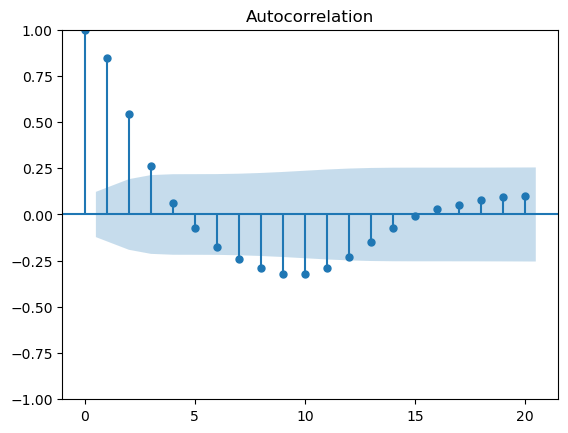

In [141]:
from statsmodels.graphics.tsaplots import plot_acf

# Identify q
plot_acf(diff_timeseries, lags=20)
plt.show()

We can see significant autocorrelation lag up to 11.

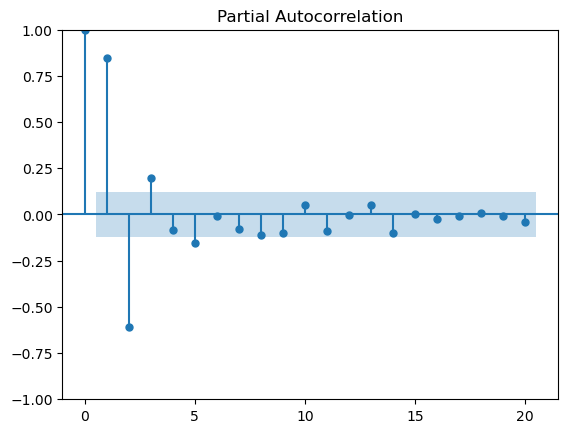

In [142]:
from statsmodels.graphics.tsaplots import plot_pacf

# Identify p
plot_pacf(diff_timeseries, lags=20)
plt.show()

We can see significant partial autocorrelation for lag up to 5.

High values for p and q can make the model more complex, potentially leading to overfitting. Simpler models (lower p and q) are generally preferred unless there's strong evidence in the data (e.g., persistent significant lags in ACF/PACF).

To this end, we will fit a simpler model (p=1, q=1), a slightly more complex model (p=2, q=3) and the comples model determined by the ACF and PACF 
(p=5, q=11).

In [165]:
arima_111 = fit_arima(timeseries, order=(1, 1, 1))   # order=(p, d, q)
arima_213 = fit_arima(timeseries, order=(2, 1, 3))
arima_5111 = fit_arima(timeseries, order=(5, 1, 11))

                               SARIMAX Results                                
Dep. Variable:               COVID-19   No. Observations:                  257
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1963.228
Date:                Thu, 12 Dec 2024   AIC                           3932.456
Time:                        23:10:38   BIC                           3943.092
Sample:                    01-04-2020   HQIC                          3936.734
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7551      0.017     43.781      0.000       0.721       0.789
ma.L1          0.5877      0.031     19.119      0.000       0.527       0.648
sigma2      2.673e+05   1.15e+04     23.174      0.0

C:\Users\Anton\miniconda3\envs\tu_mdg\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               COVID-19   No. Observations:                  257
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1942.538
Date:                Thu, 12 Dec 2024   AIC                           3897.075
Time:                        23:10:38   BIC                           3918.346
Sample:                    01-04-2020   HQIC                          3905.630
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6117      0.034     47.076      0.000       1.545       1.679
ar.L2         -0.6572      0.039    -16.817      0.000      -0.734      -0.581
ma.L1         -0.1812      0.063     -2.867      0.0

C:\Users\Anton\miniconda3\envs\tu_mdg\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Anton\miniconda3\envs\tu_mdg\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               COVID-19   No. Observations:                  257
Model:                ARIMA(5, 1, 11)   Log Likelihood               -1973.770
Date:                Thu, 12 Dec 2024   AIC                           3981.539
Time:                        23:10:40   BIC                           4041.807
Sample:                    01-04-2020   HQIC                          4005.779
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5686      0.117      4.865      0.000       0.340       0.798
ar.L2          1.6594      0.106     15.649      0.000       1.452       1.867
ar.L3         -1.1713      0.177     -6.636      0.0

C:\Users\Anton\miniconda3\envs\tu_mdg\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Key Observations

#### 1. **Model Comparison by AIC/BIC**
- **AIC (Akaike Information Criterion)** and **BIC (Bayesian Information Criterion)** are measures of model fit, balancing complexity and goodness-of-fit.
- Lower AIC/BIC values indicate a better model.
- **Results:**
  - $ (1, 1, 1) $: AIC = 3932.456, BIC = 3943.092
  - $ (2, 1, 3) $: AIC = 3897.075, BIC = 3918.346
  - $ (5, 1, 11) $: AIC = 3981.539, BIC = 4041.807
- **Best Model**:
  - Based on AIC/BIC, the $ (2, 1, 3) $ model performs the best.

#### 2. **Model Diagnostics**
Each model's residuals should behave like white noise (i.e., no autocorrelation and constant variance). This ensures the model captures the time series dynamics well.

- **Ljung-Box Test (Prob(Q))**:
  - Checks for autocorrelation in residuals. Higher $p$-values (closer to 1) indicate no significant autocorrelation.
  - $ (1, 1, 1) $: Prob(Q) = 0.01 (some residual autocorrelation present).
  - $ (2, 1, 3) $: Prob(Q) = 0.84 (no significant residual autocorrelation).
  - $ (5, 1, 11) $: Prob(Q) = 0.87 (no significant residual autocorrelation).
- **Jarque-Bera Test (Prob(JB))**:
  - Tests for normality of residuals. A $p$-value close to 0 suggests non-normality.
  - All models show significant non-normality, indicating skewed or heavy-tailed residuals.

#### 3. **Warnings**
- $ (5, 1, 11) $: The model struggles with convergence (likely due to its high complexity).
  - Non-invertible MA parameters and non-stationary AR parameters suggest overfitting or numerical instability.
  - This raises concerns about the reliability of the estimates.

#### 4. **Interpretation of Coefficients**
- Coefficients for AR and MA terms provide insights into the influence of past values and forecast errors. However, for highly complex models ($5, 1, 11$), the significance of many coefficients may be unreliable (e.g., some MA terms are insignificant in this model).

### **Summary Table for Models**

| Model        | AIC      | BIC      | Prob(Q) | Notes                                        |
|--------------|----------|----------|---------|---------------------------------------------|
| $ (1, 1, 1) $ | 3932.456 | 3943.092 | 0.01    | Some residual autocorrelation present.       |
| $ (2, 1, 3) $ | **3897.075** | **3918.346** | 0.84    | Best model: good balance of fit and complexity. |
| $ (5, 1, 11) $ | 3981.539 | 4041.807 | 0.87    | Overfitting; convergence issues; unreliable. |

#### Residual Diagnostic

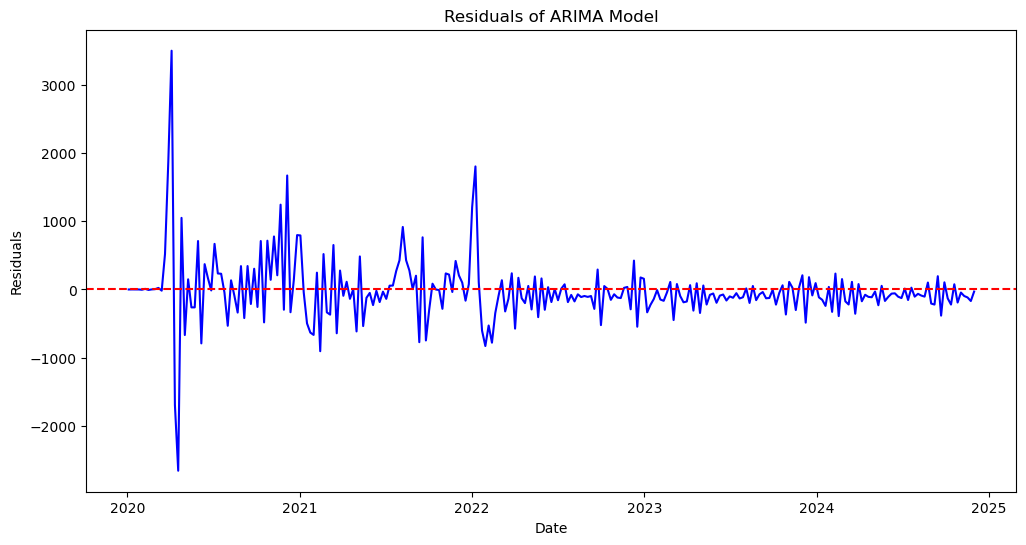

Residuals Statistics:
count     257.000000
mean      -23.918376
std       478.370359
min     -2660.030676
25%      -195.002505
50%       -63.678622
75%       100.418684
max      3504.314188
dtype: float64


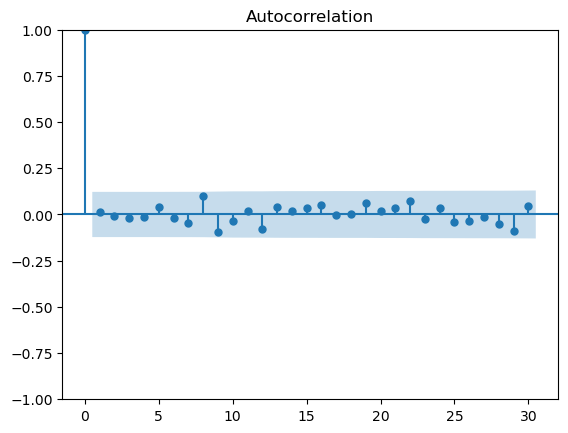

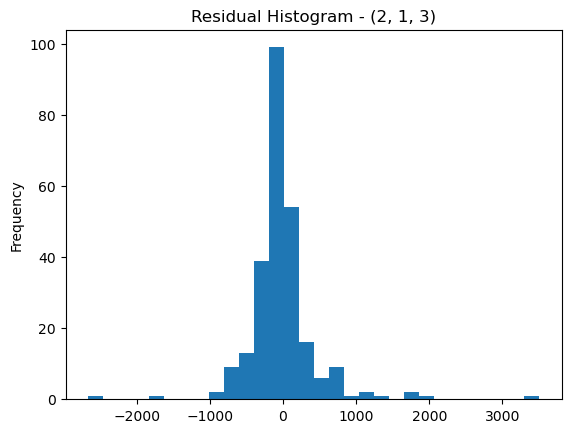

Shapiro-Wilk test p-value: 1.8001517976322002e-18
Residuals are not normally distributed.


In [167]:
analyze_residuals(arima_213)

The ACF shows that the residuals are not significantly auto-correlated (for lag > 0). The histogram illustrates the non-normality of the residuals,
 which is likely due to outliers (sharp spikes in the timeseries).


The significant non-normality of the residuals (indicated by the Jarque-Bera test) does not necessarily mean we cannot use ARIMA, but it suggests 
caution in interpreting the model results. The assumption that residuals are normally distributed help ensure reliable confidence intervals and 
hypothesis testing.

We can still work with the model and practically validate whether it is reliable.

### 5. Time Series Forecasting

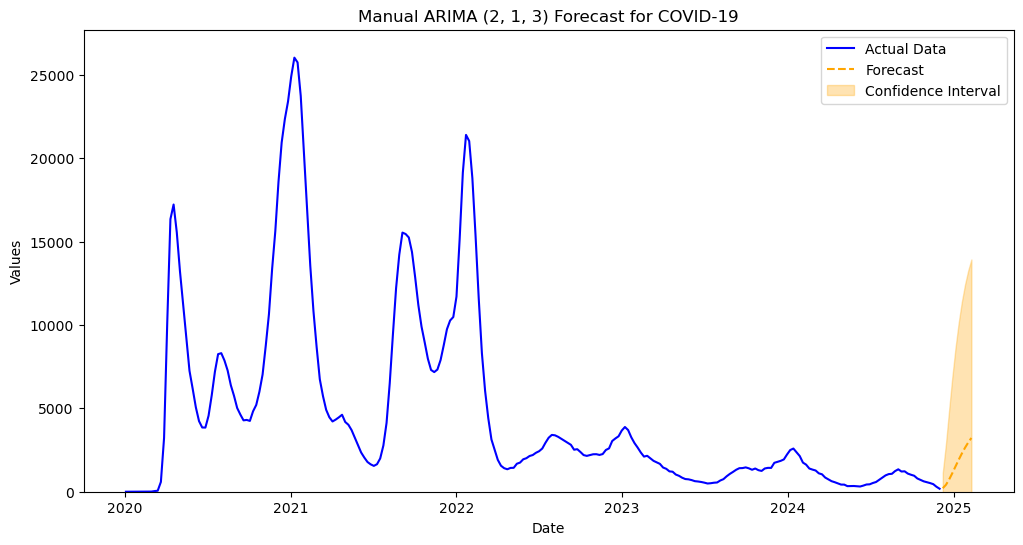

In [172]:
# Step 1: Forecast future values and extract confidence intervals
forecast_steps = 10
ci_alpha = 0.05
manual_forecast_result = arima_213.get_forecast(steps=forecast_steps)
manual_forecast = manual_forecast_result.predicted_mean
manual_conf_int = manual_forecast_result.conf_int(alpha=ci_alpha)

plot_forecast_with_confidence_intervals(
    ts=timeseries,
    forecast=manual_forecast,
    conf_int=manual_conf_int,
    title=f"Manual ARIMA (2, 1, 3) Forecast for {ts_metric}",
    ylim=(0, None)
)

### 6. Automation

In [170]:
auto_arima = auto_fit_arima(timeseries, seasonal=True, alpha=ci_alpha, ic='aic')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3908.060, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4352.553, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4032.389, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4103.438, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4350.555, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3908.483, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3908.963, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3909.939, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3934.456, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3907.832, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3916.211, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3909.841, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3966.271, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : 

In [171]:
# Get AIC and BIC values
manual_aic = arima_213.aic
manual_bic = arima_213.bic

auto_aic = auto_arima.aic()
auto_bic = auto_arima.bic()

print(f"Manual ARIMA AIC: {manual_aic}, BIC: {manual_bic}")
print(f"Automatic ARIMA AIC: {auto_aic}, BIC: {auto_bic}")



Manual ARIMA AIC: 3897.075316065237, BIC: 3918.3463807321145
Automatic ARIMA AIC: 3905.831619104867, BIC: 3923.557506327265


The automatic fit appears to be yet a little bit better than the manual fit. Let's visualize it!

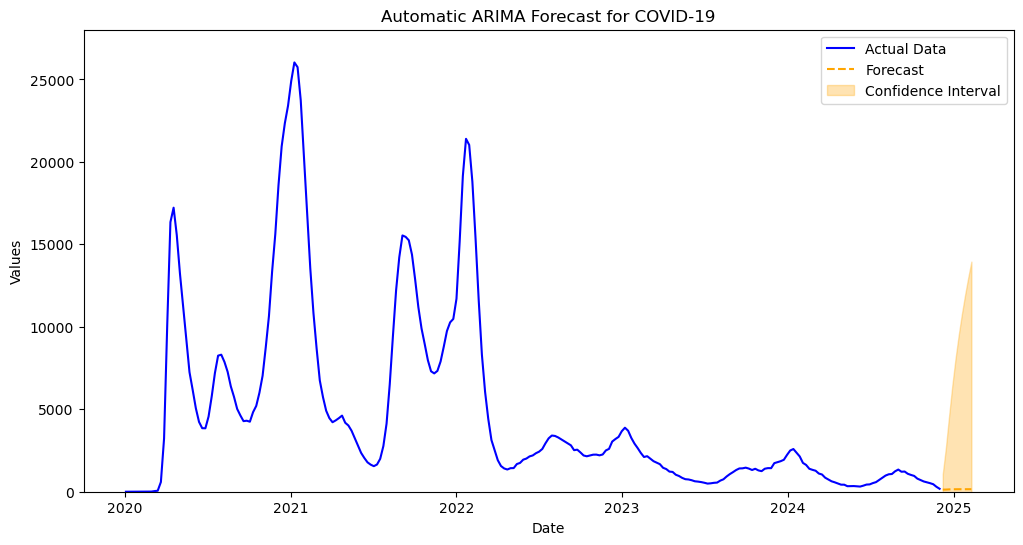

In [182]:
last_date = timeseries.index[-1]  # Get the last date from the actual data
forecast_index = pd.date_range(start=last_date + pd.Timedelta(1, unit='D'), periods=forecast_steps, freq='W-SAT')

# Automatic forecast
auto_forecast_result = auto_arima.predict(n_periods=forecast_steps, return_conf_int=True)
auto_forecast = pd.Series(auto_forecast_result[0], index=forecast_index)
auto_conf_int = pd.DataFrame(auto_forecast_result[1], columns=["Lower CI", "Upper CI"], index=forecast_index)

# Plot Automatic ARIMA
plot_forecast_with_confidence_intervals(
    ts=timeseries,
    forecast=auto_forecast,
    conf_int=auto_conf_int,
    title=f"Automatic ARIMA Forecast for {ts_metric}",
    ylim=(0, None)
)
